In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.vgg19 import VGG19
import tensorflow_datasets as tfds

!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [3]:
img_size = 224
batch_size = 16
epochs = 40
learning_rate = 0.001
weight_decay = 0.0001
learning_rate = 1e-3

In [4]:
def normalize_img(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (img_size, img_size))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

del raw_train
del raw_validation
del raw_test

In [6]:
train = train.unbatch().batch(batch_size,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(batch_size,drop_remainder=True).repeat()

In [7]:
steps_per_epoch = metadata.splits["train"].num_examples / batch_size 
validation_steps = metadata.splits["validation"].num_examples / batch_size

In [8]:
inceptionResNetV2_model = tf.keras.applications.InceptionResNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(img_size, img_size,3),
    pooling='avg'
    )

for layer in inceptionResNetV2_model.layers:
    layer.trainable = False


In [9]:
model = tf.keras.Sequential([
    inceptionResNetV2_model,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(102)
])

In [10]:
def run_experiment(model):

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  hist = model.fit(
    x=train,
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history
  
  model.load_weights(checkpoint_filepath)

  return hist

In [11]:
hist = run_experiment(model)

Epoch 1/10
63/63 [==============================] - 74s 279ms/step - loss: 4.1748 - accuracy: 0.1523 - val_loss: 4.1751 - val_accuracy: 0.1475
Epoch 2/10
63/63 [==============================] - 19s 294ms/step - loss: 3.2151 - accuracy: 0.2627 - val_loss: 3.6419 - val_accuracy: 0.1904
Epoch 3/10
63/63 [==============================] - 18s 289ms/step - loss: 2.7449 - accuracy: 0.3379 - val_loss: 2.9369 - val_accuracy: 0.3027
Epoch 4/10
63/63 [==============================] - 15s 242ms/step - loss: 2.2912 - accuracy: 0.4287 - val_loss: 2.6539 - val_accuracy: 0.3320
Epoch 5/10
63/63 [==============================] - 15s 230ms/step - loss: 2.0776 - accuracy: 0.4424 - val_loss: 2.3246 - val_accuracy: 0.3945
Epoch 6/10
63/63 [==============================] - 16s 251ms/step - loss: 1.8614 - accuracy: 0.4941 - val_loss: 2.2419 - val_accuracy: 0.4004
Epoch 7/10
63/63 [==============================] - 18s 290ms/step - loss: 1.7426 - accuracy: 0.5205 - val_loss: 1.9475 - val_accuracy: 0.4551

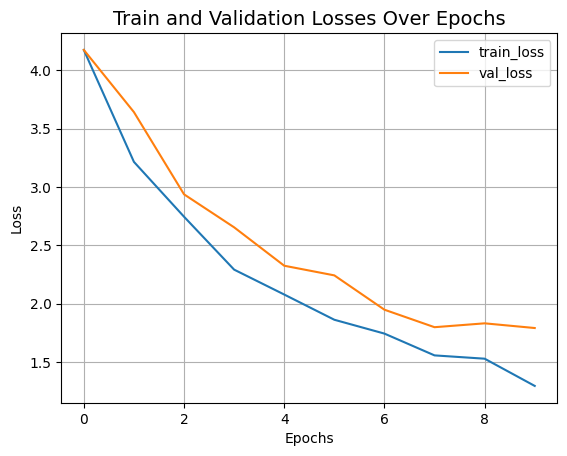

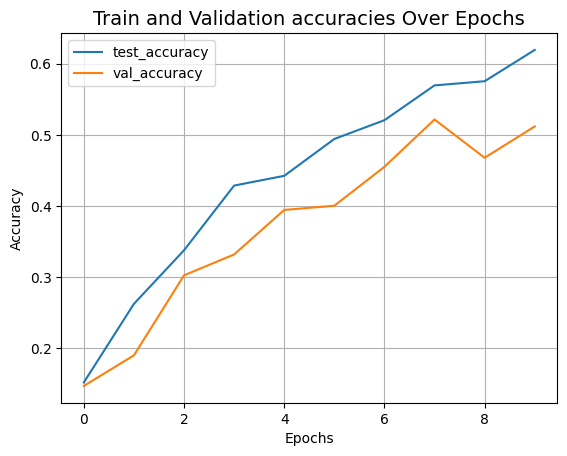

In [12]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
del train
del hist

In [14]:
model.evaluate(test)

32/32 [==============================] - 13s 219ms/step - loss: 1.8900 - accuracy: 0.4951


[1.8899866342544556, 0.4950980246067047]

In [15]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

32/32 [==============================] - 8s 157ms/step


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.4950980392156863


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Obtendo as previsões do modelo para o conjunto de teste
y_pred = predicted_classes

# Obtendo os rótulos verdadeiros do conjunto de teste
y_true = true_classes

# Calculando o recall ponderado
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Calculando a precisão ponderada
weighted_precision = precision_score(y_true, y_pred, average='weighted')

# Calculando o F1-score ponderado
weighted_f1_score = f1_score(y_true, y_pred, average='weighted')

# Imprimindo os resultados
print("Weighted Recall:", weighted_recall)
print("Weighted Precision:", weighted_precision)
print("Weighted F1-Score:", weighted_f1_score)

Weighted Recall: 0.4950980392156863
Weighted Precision: 0.5869700295744532
Weighted F1-Score: 0.45836720847191215


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
